<a href="https://colab.research.google.com/github/changsin/Medium/blob/main/notebooks/Dedupe_Rainbow_sunset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable solutions to detect duplicates

In [1]:
!pip install -q youtube-dl

     |████████████████████████████████| 1.9 MB 9.5 MB/s 


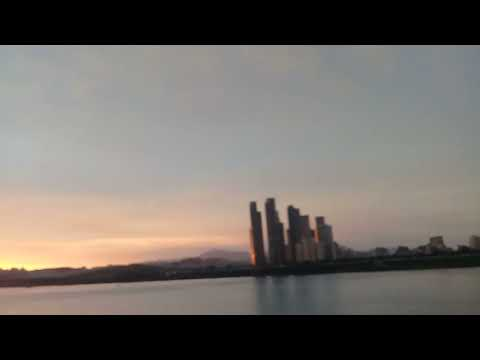

In [16]:
from IPython.display import YouTubeVideo

rainbow_sunset = "rainbow_sunset"
rainbow_sunset_id = 'I1wDZICq8XY'
YouTubeVideo(rainbow_sunset_id)

In [18]:
def download_youtube(youtube_id, save_filename):
  !youtube-dl -f 'bestvideo[ext=mp4]' --output $save_filename".%(ext)s" https://www.youtube.com/watch?v=$youtube_id

download_youtube(rainbow_sunset_id, rainbow_sunset)

[youtube] I1wDZICq8XY: Downloading webpage
[youtube] I1wDZICq8XY: Downloading MPD manifest
[download] Destination: rainbow_sunset.mp4
[download] 100% of 1.26MiB in 00:00


In [19]:
def to_images(youtube_id, save_folder):
  !test -d $save_folder && rm $save_folder/*
  !mkdir $save_folder
  !ffmpeg -i $youtube_id".mp4" -filter:v fps=10 $save_folder/out%05d.jpg

to_images(rainbow_sunset, rainbow_sunset)

rm: cannot remove 'rainbow_sunset/*': No such file or directory
mkdir: cannot create directory ‘rainbow_sunset’: File exists
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-l

## imports

In [5]:
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
"""
Methods for loading and visualizing images
"""

IMAGE_SIZE = 320

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
    files = glob_files(path, file_type)

    images = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # normalize
            image = image / 256
            images.append(image)
        else:
            print(file, ' is not an image file')

    return np.array(images)

def plot_images(X, idx=None, limit=20):
  fig = plt.figure(figsize=(50,60))

  # The number of images for plotting is limited to 50
  end_id = len(X) if len(X) < limit else limit
  if idx is None:
    idx = range(0, end_id)

  i = 0
  for id in idx:
    axis = fig.add_subplot(5, 5, i+1)
    plt.axis('off')
    image = X[id]
    plt.imshow(image)
    i += 1

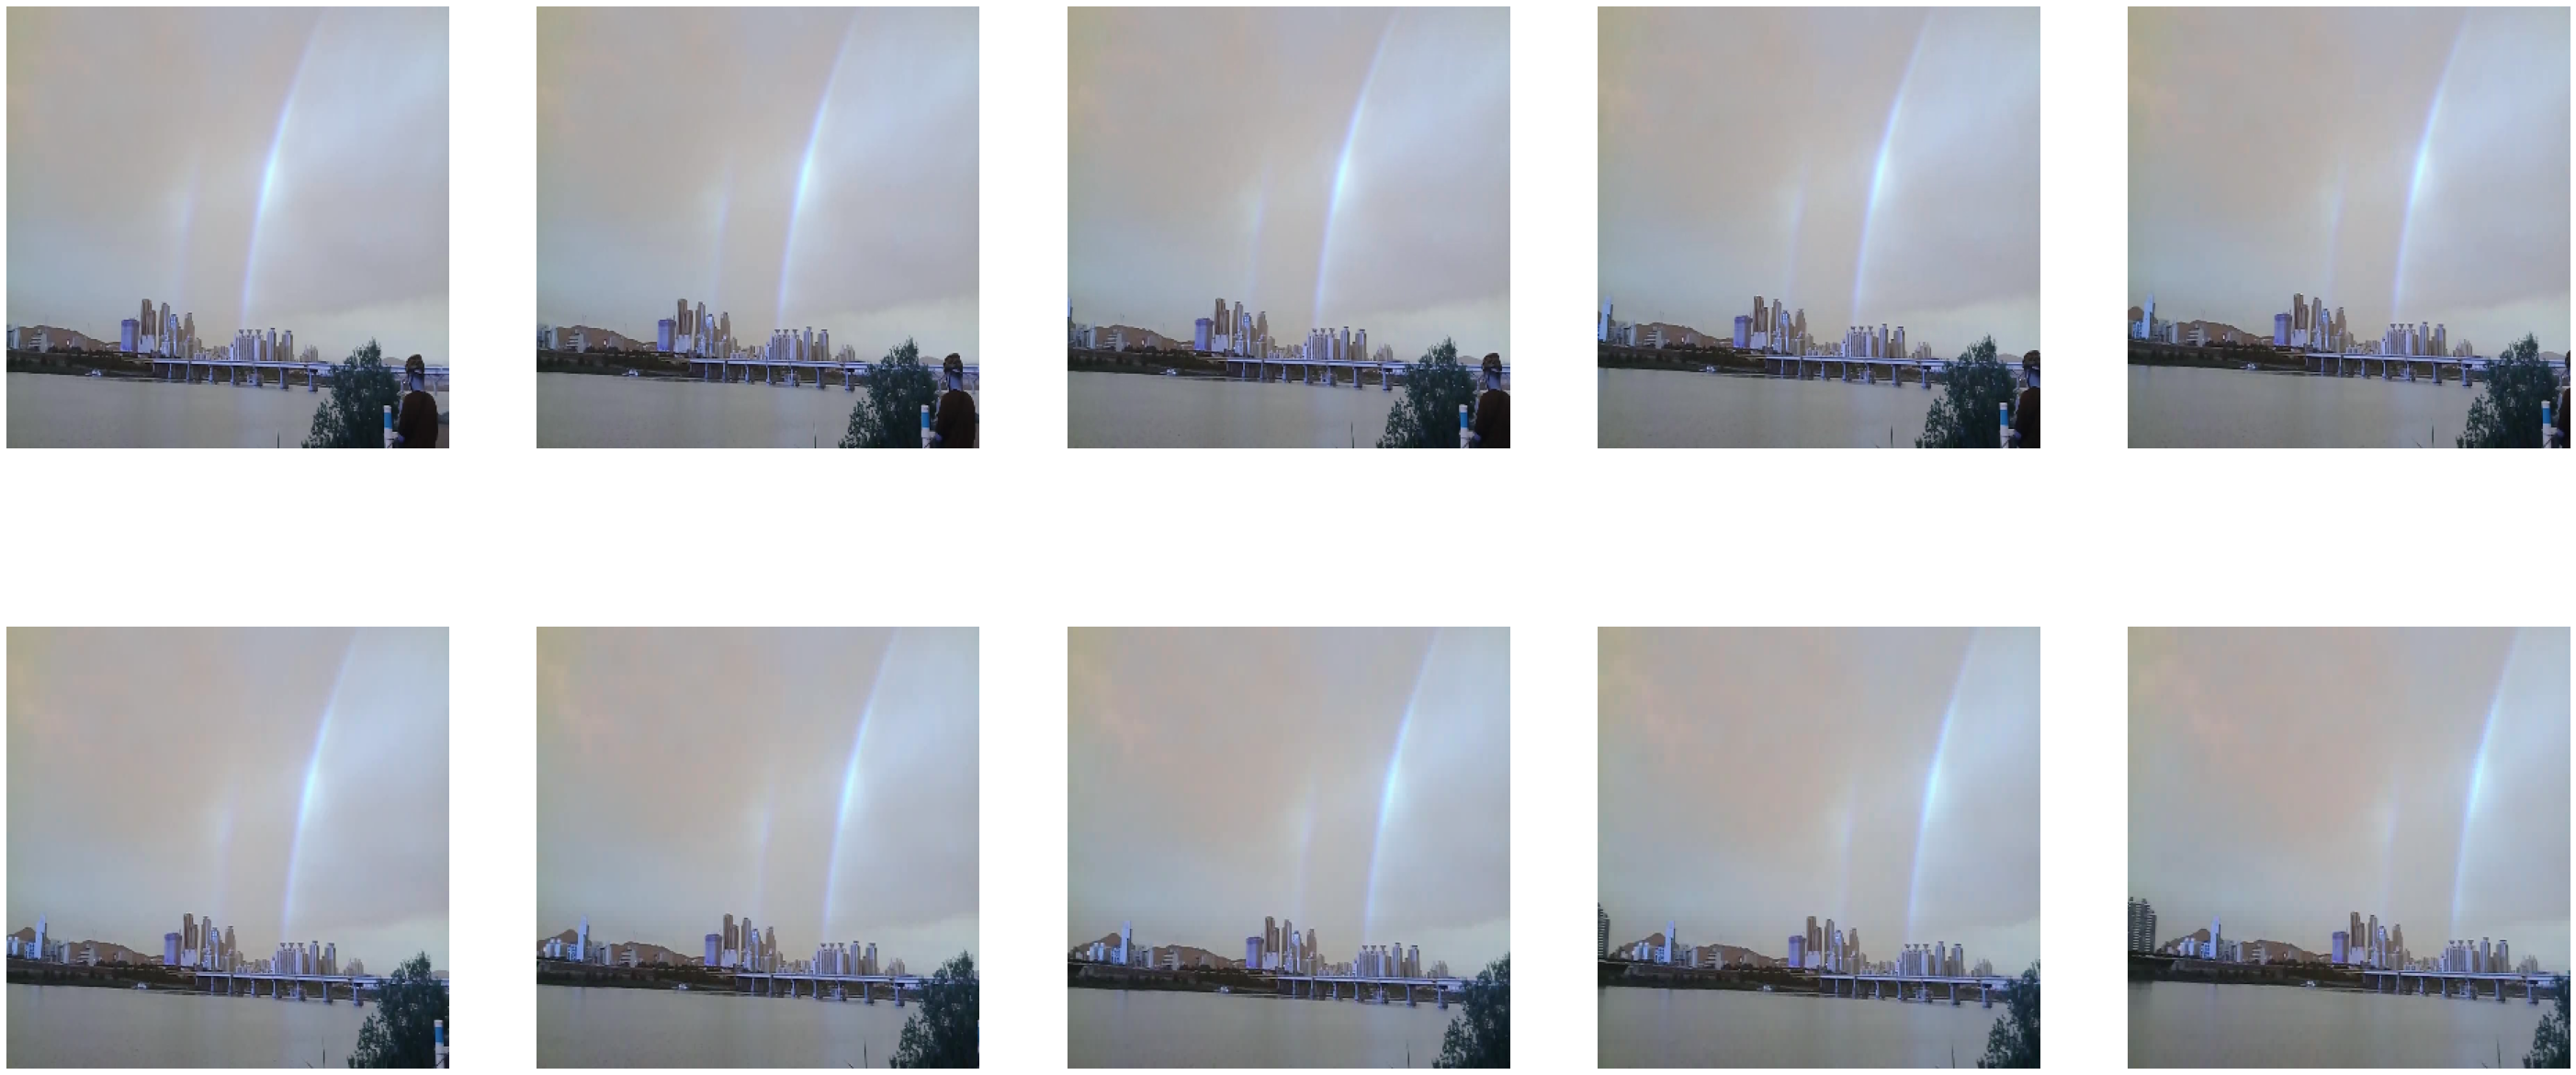

In [20]:
images = load_images(rainbow_sunset)
images.shape
plot_images(images, limit=10)

# Cluster

In [8]:
def get_pca_reduced(X_features, dimensions=2):
  X_features_flatten = X_features.reshape(X_features.shape[0], -1)
  pca = PCA(dimensions)

  X_features_pca_reduced = pca.fit_transform(X_features_flatten)

  return X_features_pca_reduced, pca


def get_clusters(X_reduced, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X_reduced)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(path, K=2):
  X = load_images(path)
  plot_images(X)
  X_reduced, pca = get_pca_reduced(X, dimensions=K)

  X_clusters, kmeans = get_clusters(X_reduced, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  return X_reduced, kmeans

In [9]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("K-means clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

[[ 79.34138652  -4.37693964]
 [-41.32363881   2.27965606]]
{0: array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])}


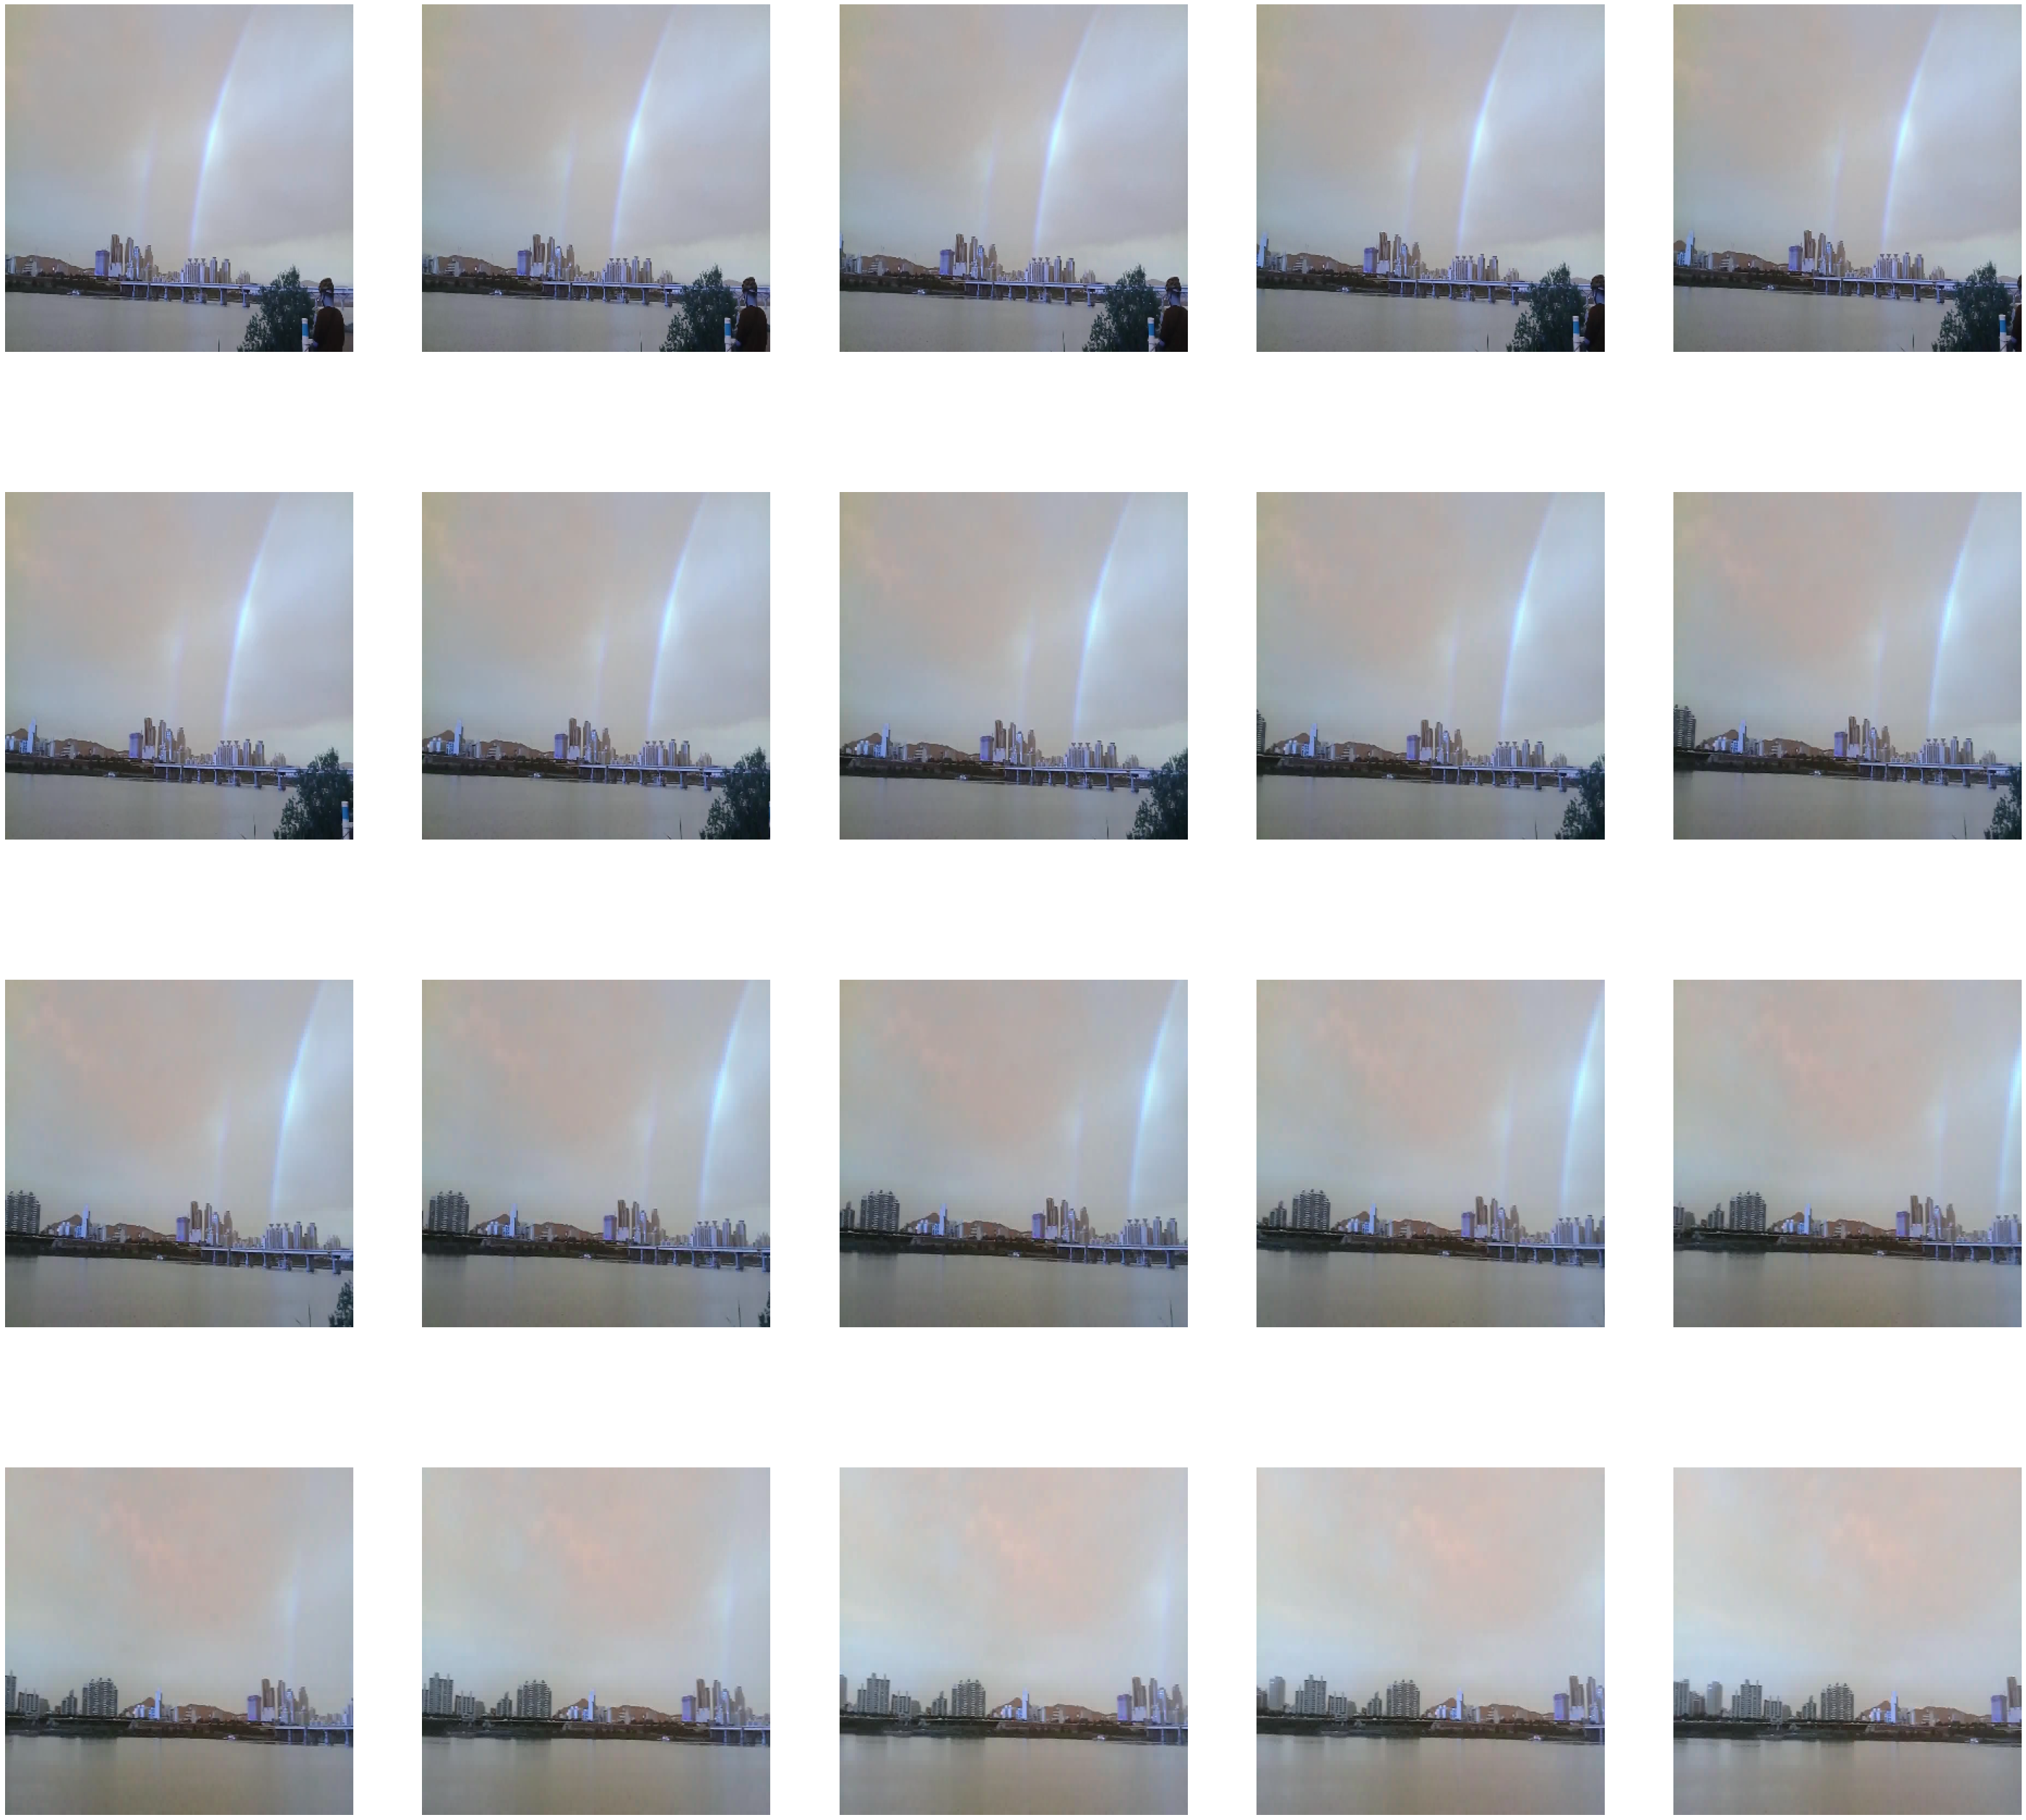

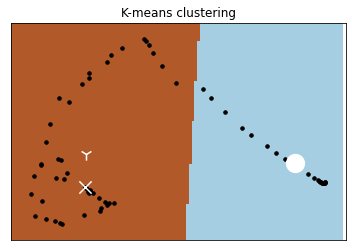

In [21]:
X_reduced_rs, kmeans_rs = cluster_images(rainbow_sunset)
plot_data_in_clusters(X_reduced_rs, kmeans=kmeans_rs, idx=[1])

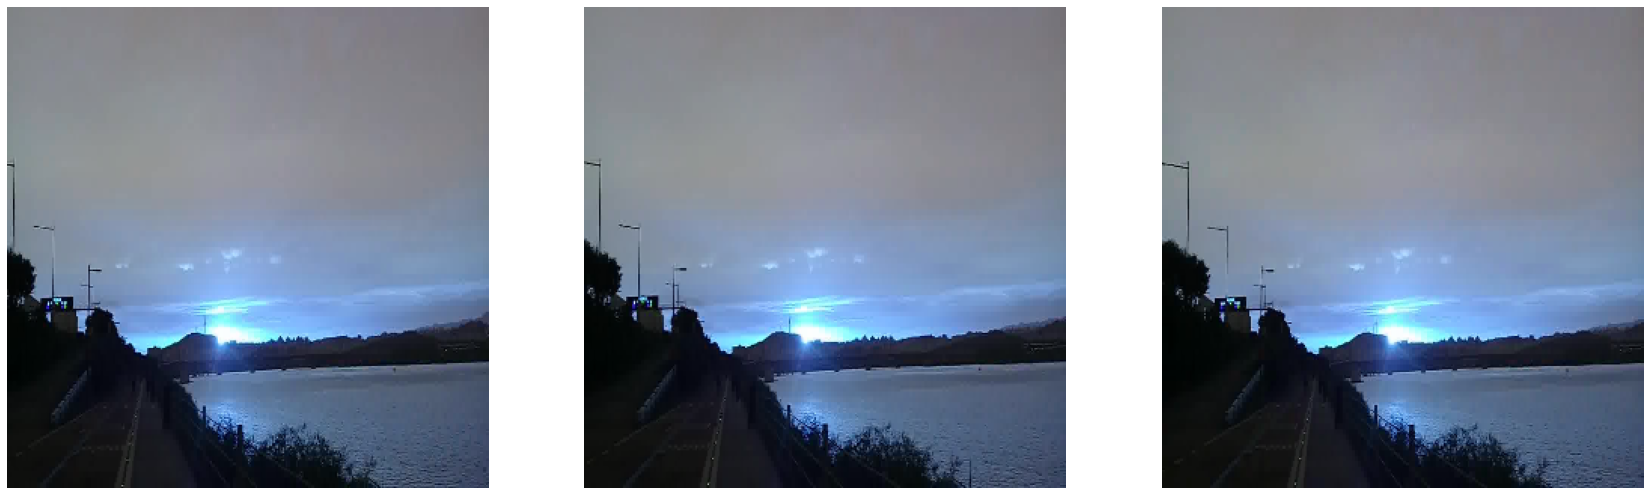

In [11]:
plot_images(images, idx=[55, 56, 57])

## Save the centroids

# A new video - migrating birds

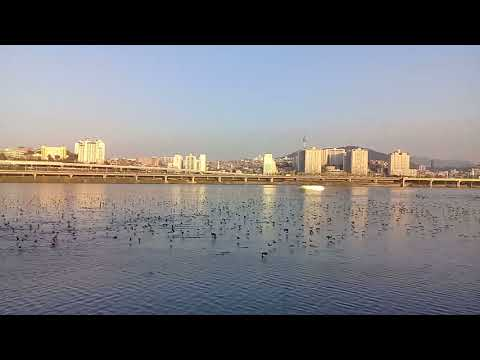

In [12]:
migrating_birds = "migrating_birds"
migrating_birds_id = '-0jhgfyzINQ'
YouTubeVideo(migrating_birds_id)

In [14]:
download_youtube(migrating_birds_id, migrating_birds)
to_images(migrating_birds, migrating_birds)

[youtube] -0jhgfyzINQ: Downloading webpage
[youtube] -0jhgfyzINQ: Downloading MPD manifest
[download] Destination: migrating_birds.mp4
[download] 100% of 2.36MiB in 00:00
rm: cannot remove 'migrating_birds/*': No such file or directory
mkdir: cannot create directory ‘migrating_birds’: File exists
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --en

In [15]:
def to_json(path, data):
    """
    save json data to path
    """
    with open(path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

def from_json(path):
    """
    save json data to path
    """
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

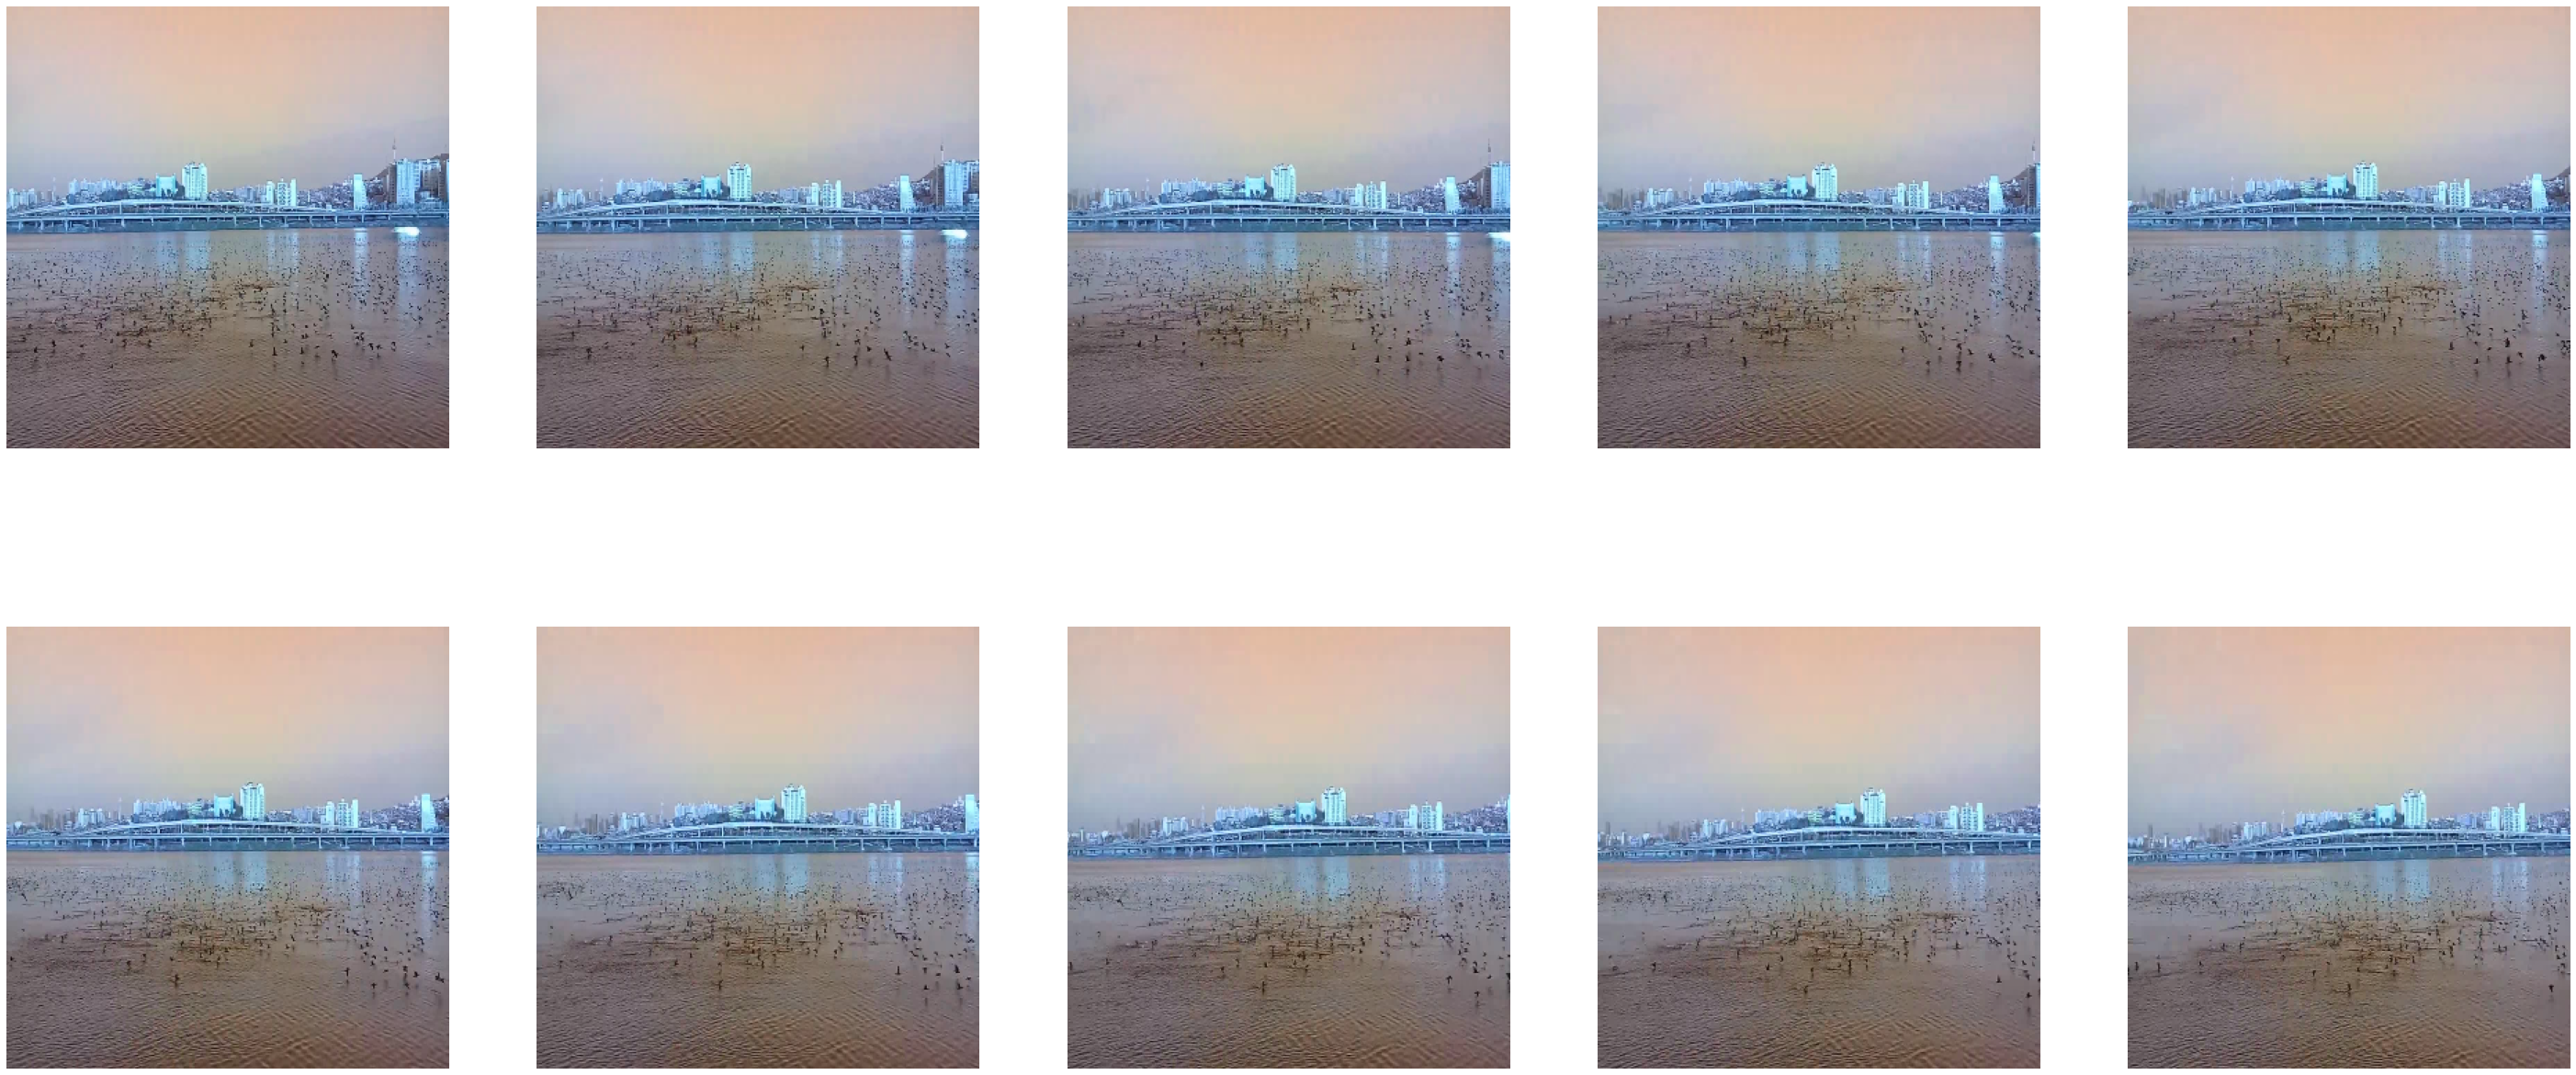

In [23]:
images_mb = load_images(migrating_birds)
images_mb.shape
plot_images(images_mb, limit=10)

In [24]:
kmeans_rs.cluster_centers_

array([[ 79.34138652,  -4.37693964],
       [-41.32363881,   2.27965606]])

In [ ]:


# Calculate distances of all points
distances = cdist(X_train_pca, X_train_pca)